#**Step 1: Install All the Required Packages**

In [1]:
!pip install trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 7.4 MB/s eta 0:00:00ta 0:00:01


In [2]:
# Restart the kernel after running this cell
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


#**Step 2: Import All the Required Libraries**

In [3]:
!pip install peft

In [4]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 MB 22.7 MB/s eta 0:00:00:00:0100:01


In [5]:
!pip install scikit-learn

In [6]:
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

#**In case of Llama 2, the following prompt template is used for the chat models**

System Prompt (optional) to guide the model


User prompt (required) to give the instruction


Model Answer (required)

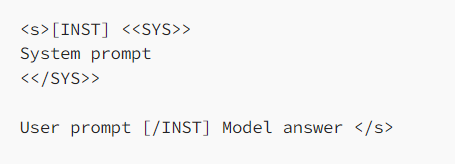

#We will reformat our instruction dataset to follow Llama 2 template.

- Orignal Dataset: https://huggingface.co/datasets/timdettmers/openassistant-guanaco

- Reformat Dataset following the Llama 2 template with 1k sample: https://huggingface.co/datasets/mlabonne/guanaco-llama2-1k

- Complete Reformat Dataset following the Llama 2 template: https://huggingface.co/datasets/mlabonne/guanaco-llama2

To know how this dataset was created, you can check this notebook.  

https://colab.research.google.com/drive/1Ad7a9zMmkxuXTOh1Z7-rNSICA4dybpM2?usp=sharing

In [7]:
import pandas as pd

In [8]:
qna_db=pd.read_excel("/kaggle/input/final-qna-dataset/QnA_Sheet_Data_Final.xlsx")

In [9]:
qna_db.drop(['Contributors', 'Key Concerns', 'Employee_ID'], axis=1, inplace=True)

In [10]:
qna_db.head()

,Question,Response Set
0,You recently took casual leave. Did it impact ...,"<s>[INST] No, I planned my work ahead, so ever..."
1,Your meeting attendance is lower than average....,<s>[INST] I find most meetings unnecessary. [/...
2,Your activity levels in Teams and Emails are m...,"<s>[INST] No, I feel comfortable with the curr..."
3,Your work hours are the highest in this group....,"<s>[INST] No, I feel comfortable with the curr..."
4,Since you are being considered for a promotion...,<s>[INST] I need to work on my leadership skil...


In [11]:
qna_db.dropna(inplace=True)

In [12]:
import re
def extract_prompts(response_text):
    """
    Extracts the user prompt and model answer from the response text.
    Expects the format: <s>[INST] User prompt [/INST] Model answer</s>
    """
    pattern = r"<s>\[INST\]\s*(.*?)\s*\[/INST\]\s*(.*?)\s*</s>"
    match = re.search(pattern, response_text, re.DOTALL)
    if match:
        user_prompt = match.group(1)
        model_answer = match.group(2)
        return user_prompt, model_answer
    else:
        return None, None
        
def create_new_format(row):
    system_prompt = row['Question']
    response_text = row['Response Set']
    user_prompt, model_answer = extract_prompts(response_text)
    
    # If extraction fails, use the original response_text
    if user_prompt is None or model_answer is None:
        return response_text
    
    # Construct the new string format
    new_string = (f"<s>[INST] <<SYS>>\n{system_prompt}\n<</SYS>>\n"
                  f"{user_prompt} [/INST] {model_answer}</s>")
    return new_string

In [13]:
qna_db['New Format'] = qna_db.apply(create_new_format, axis=1)

In [14]:
new_db=qna_db['New Format'].to_numpy()

In [15]:
new_db[5]

"<s>[INST] <<SYS>>\nYour engagement in Teams and Emails is quite low. Are there any challenges preventing you from participating more?\n<</SYS>>\nI prefer direct calls instead of messages. [/INST] That's a valid approach! Would you like an option to log direct calls as collaboration activity?</s>"

### Note: You don’t need to follow a specific prompt template if you’re using the base Llama 2 model instead of the chat version.

#**How to fine tune Llama 2**

- Free Google Colab offers a 15GB Graphics Card (Limited Resources --> Barely enough to store Llama 2–7b’s weights)

- We also need to consider the overhead due to optimizer states, gradients, and forward activations

- Full fine-tuning is not possible here: we need parameter-efficient fine-tuning (PEFT) techniques like LoRA or QLoRA.

- To drastically reduce the VRAM usage, we must fine-tune the model in 4-bit precision, which is why we’ll use QLoRA here.

#**Step 3**

1. Load a llama-2-7b-chat-hf model (chat model)
2. Train it on the mlabonne/guanaco-llama2-1k (1,000 samples), which will produce our fine-tuned model Llama-2-7b-chat-finetune

QLoRA will use a rank of 64 with a scaling parameter of 16. We’ll load the Llama 2 model directly in 4-bit precision using the NF4 type and train it for one epoch

In [16]:
# The model that you want to train from the Hugging Face hub
model_name = "NousResearch/Llama-2-7b-chat-hf"

# The instruction dataset to use
dataset_name = "mlabonne/guanaco-llama2-1k"

# Fine-tuned model name
new_model = "india_name_trainer"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "/kaggle/working/"

# Number of training epochs
num_train_epochs = 15

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1


# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

#**Step 4:Load everything and start the fine-tuning process**

1. First of all, we want to load the dataset we defined. Here, our dataset is already preprocessed but, usually, this is where you would reformat the prompt, filter out bad text, combine multiple datasets, etc.


2. Then, we’re configuring bitsandbytes for 4-bit quantization.


3. Next, we're loading the Llama 2 model in 4-bit precision on a GPU with the corresponding tokenizer.


4. Finally, we're loading configurations for QLoRA, regular training parameters, and passing everything to the SFTTrainer. The training can finally start!

In [17]:
!pip install openpyxl

In [18]:
from datasets import Dataset

In [19]:
import re
import pandas as pd

# Function to extract all Q&A pairs from Response Set
def extract_all_prompts(response_text):
    """
    Extracts all user prompts and model answers from the response text.
    """
    pattern = r"<s>\[INST\]\s*(.*?)\s*\[/INST\]\s*(.*?)\s*</s>"
    matches = re.findall(pattern, response_text, re.DOTALL)
    
    # Return list of (user_prompt, model_answer) tuples
    return matches if matches else []

# Function to create expanded dataset with all Q&A pairs
def create_expanded_dataset(qna_db):
    expanded_rows = []
    
    for _, row in qna_db.iterrows():
        system_prompt = row['Question']
        response_text = row['Response Set']
        
        # Extract all Q&A pairs
        qa_pairs = extract_all_prompts(response_text)
        
        # If no pairs found, skip or handle as needed
        if not qa_pairs:
            continue
            
        # Create a new row for each Q&A pair
        for user_prompt, model_answer in qa_pairs:
            new_string = (f"<s>[INST] <<SYS>>\n{system_prompt}\n<</SYS>>\n"
                        f"{user_prompt} [/INST] {model_answer}</s>")
            expanded_rows.append(new_string)
    
    # Create new DataFrame with all expanded rows
    return pd.DataFrame(expanded_rows, columns=['text'])

# Replace your existing transformation with this
new_db_pd = create_expanded_dataset(qna_db)


In [20]:
# Set display options to show the full content of columns
import pandas as pd

# Option 1: Remove truncation for all columns
pd.set_option('display.max_colwidth', None)

# Then view your data again
new_db_pd.head()

,text
0,"<s>[INST] <<SYS>>\nYou recently took casual leave. Did it impact your workflow or team communication?\n<</SYS>>\nNo, I planned my work ahead, so everything was smooth. [/INST] That's great! Do you feel that planning ahead reduces stress at work?</s>"
1,"<s>[INST] <<SYS>>\nYou recently took casual leave. Did it impact your workflow or team communication?\n<</SYS>>\nYes, I had trouble catching up with my tasks after returning. [/INST] I see. Would having a buffer day to settle back in help you manage post-leave workload better?</s>"
2,"<s>[INST] <<SYS>>\nYou recently took casual leave. Did it impact your workflow or team communication?\n<</SYS>>\nNot really, but I missed an important team discussion. [/INST] Understood. Would you find it helpful if key meeting summaries were shared automatically?</s>"
3,"<s>[INST] <<SYS>>\nYou recently took casual leave. Did it impact your workflow or team communication?\n<</SYS>>\nI was sick, so it was hard to manage pending tasks after my leave. [/INST] That makes sense. Do you think a flexible return schedule would help in such cases?</s>"
4,"<s>[INST] <<SYS>>\nYou recently took casual leave. Did it impact your workflow or team communication?\n<</SYS>>\nI haven't taken leave recently, maybe the data is incorrect. [/INST] Thanks for pointing that out! I'll check the records. Would you like to manually log recent leaves?</s>"


In [21]:
# Rename column if needed
#transformed_dataset = transformed_dataset.rename(columns={transformed_dataset.columns[0]: "text"})
transformed_dataset = new_db_pd
# transformed_dataset = transformed_dataset.drop(columns=["Transformed_Train"])

# Convert to Hugging Face Dataset
dataset = Dataset.from_pandas(transformed_dataset)

# Check first sample
print(dataset[0])  # Expected: {'text': '### Human: My PIN is five thousand six. ### ...'}


{'text': "<s>[INST] <<SYS>>\nYou recently took casual leave. Did it impact your workflow or team communication?\n<</SYS>>\nNo, I planned my work ahead, so everything was smooth. [/INST] That's great! Do you feel that planning ahead reduces stress at work?</s>"}


In [22]:
# Create train/validation split
from sklearn.model_selection import train_test_split

# Split the dataset into 90% train and 10% validation
train_val_dict = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = train_val_dict['train']
valid_dataset = train_val_dict['test']

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(valid_dataset)}")

Training samples: 915, Validation samples: 102


In [23]:
from transformers import DataCollatorForSeq2Seq

In [24]:
!pip install -U bitsandbytes

In [25]:
!pip install flash-attn --no-build-isolation


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 55.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.7.4.post1-cp310-cp310-linux_x86_64.whl size=187797312 sha256=b267f80a08e516292cdd748056a2178a45b8abedf7fca123292eb17c21c8c87c
  Stored in directory: /root/.cache/pip/wheels/59/ce/d5/08ea07bfc16ba218dc65a3a7ef9b6a270530bcbd2cea2ee1ca
Successfully built flash-attn


In [26]:
torch.cuda.set_device(0)
torch.set_default_tensor_type('torch.cuda.FloatTensor')

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [27]:
# Enhanced GPU memory configuration
import torch
import multiprocessing
from trl import SFTTrainer, SFTConfig
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model

# Configure multiprocessing for CUDA compatibility
if __name__ == '__main__':
    multiprocessing.set_start_method('spawn', force=True)

# Clear GPU memory aggressively
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()

# Import early stopping callback
from transformers import EarlyStoppingCallback

# Create early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,        # Stop if no improvement for 3 evaluation calls
    early_stopping_threshold=0.01     # Minimum change to qualify as improvement
)

# Memory-optimized model configuration
target_modules = [
    "q_proj", "k_proj", "v_proj", "o_proj",
    "gate_proj", "down_proj", "up_proj"
]

# Enhanced quantization configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
    bnb_4bit_use_double_quant=True,  # Enable nested quantization
    llm_int8_threshold=6.0           # Optimize outlier handling
)

# Optimized model loading with memory mapping
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",               # Allow automatic device placement
    torch_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
    # Removed attn_implementation to avoid flash attention error:
    # attn_implementation="flash_attention_2",
    low_cpu_mem_usage=True
)

# Memory-aware training configuration
model.config.use_cache = False
# Removed gradient checkpointing to ensure trainable parameters are in the grad graph
# model.gradient_checkpointing_enable()
model.config.pretraining_tp = 1

# Tokenizer with optimized padding
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True,
    padding_side="right",
    use_fast=True                     # Enable fast tokenization
)
tokenizer.pad_token = tokenizer.eos_token

# Memory-efficient LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r // 2,                   # Reduce rank for memory savings
    bias="none",
    target_modules=target_modules,
    task_type="CAUSAL_LM",
    layers_to_transform=list(range(0, 32, 2))  # Train every other layer
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# Memory-optimized training arguments
training_args = SFTConfig(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=max(1, per_device_train_batch_size // 2),
    per_device_eval_batch_size=max(1, per_device_eval_batch_size // 2),  # Added for validation
    gradient_accumulation_steps=gradient_accumulation_steps * 2,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
    save_steps=save_steps,
    logging_steps=logging_steps,
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported(),
    report_to="tensorboard",
    # Change these evaluation settings
    evaluation_strategy="epoch",      # Evaluate after each epoch
    save_strategy="epoch",            # Save after each epoch
    load_best_model_at_end=True,      # Load best model at the end of training
    metric_for_best_model="eval_loss", # Use eval loss as the metric
    greater_is_better=False,          # Lower loss is better
    optim="paged_adamw_8bit",
    max_length=512,
    dataset_text_field="text",
    packing=True,
    dataloader_pin_memory=False
)

# Create memory-optimized trainer
trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,      # Changed from dataset to train_dataset
    eval_dataset=valid_dataset,       # Added validation dataset
    args=training_args,
    callbacks=[early_stopping_callback] # Added early stopping callback
)

# Execute training with memory monitoring
trainer.train()

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

trainable params: 39,976,960 || all params: 6,778,392,576 || trainable%: 0.5898


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Converting train dataset to ChatML:   0%|          | 0/915 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/915 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/915 [00:00<?, ? examples/s]

Packing train dataset:   0%|          | 0/915 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/102 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/102 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/102 [00:00<?, ? examples/s]

Packing eval dataset:   0%|          | 0/102 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,5.311500,1.537576
2,3.020100,0.947347
3,1.554500,0.765613
4,1.238400,0.738304
5,0.878900,0.756361
6,0.697200,0.824252
7,0.493800,0.935404


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

TrainOutput(global_step=252, training_loss=1.6893172169488573, metrics={'train_runtime': 2998.54, 'train_samples_per_second': 0.715, 'train_steps_per_second': 0.18, 'total_flos': 2.042144625578803e+16, 'train_loss': 1.6893172169488573})

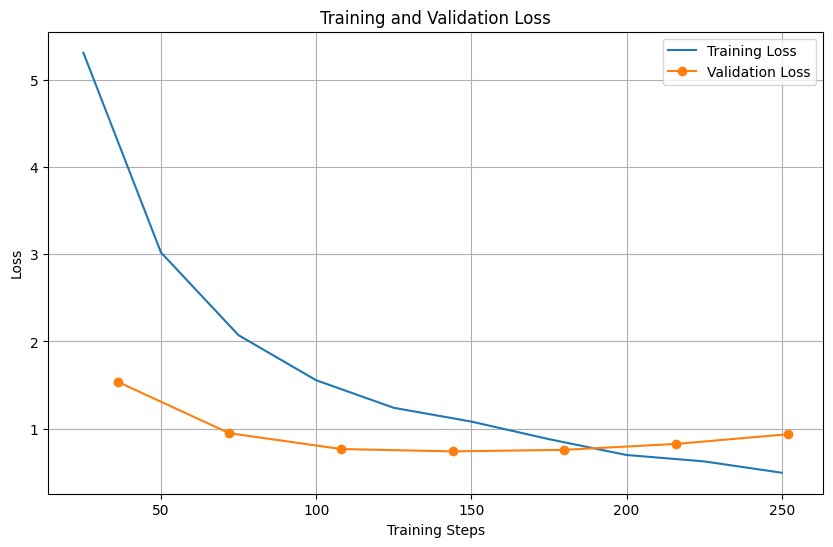

Best validation loss: 0.738303542137146
Stopped after 7 evaluations


In [28]:
# Visualize training metrics
import matplotlib.pyplot as plt
import numpy as np

# Extract training logs
training_logs = trainer.state.log_history

# Separate training and validation logs
train_logs = [log for log in training_logs if 'loss' in log and 'eval_loss' not in log]
eval_logs = [log for log in training_logs if 'eval_loss' in log]

# Plot training and validation loss
if train_logs and eval_logs:
    plt.figure(figsize=(10, 6))
    
    # Training loss
    train_steps = [log['step'] for log in train_logs]
    train_loss = [log['loss'] for log in train_logs]
    plt.plot(train_steps, train_loss, label='Training Loss')
    
    # Validation loss
    eval_steps = [log['step'] for log in eval_logs]
    eval_loss = [log['eval_loss'] for log in eval_logs]
    plt.plot(eval_steps, eval_loss, label='Validation Loss', marker='o')
    
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_validation_loss.png')
    plt.show()
    
    print(f"Best validation loss: {min(eval_loss)}")
    print(f"Stopped after {len(eval_logs)} evaluations")
else:
    print("No sufficient logs found for plotting")

In [29]:
trainer.save_model("model1")
# Save trained model
# trainer.model.save_pretrained(new_model)

In [30]:
!dir

checkpoint-108	checkpoint-216	checkpoint-72  training_validation_loss.png
checkpoint-144	checkpoint-252	model1
checkpoint-180	checkpoint-36	runs


In [31]:
import shutil

# Zip the model directory
shutil.make_archive('model1z', 'zip', '/kaggle/working/model1')

'/kaggle/working/model1z.zip'

In [32]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/model1z.zip')

/kaggle/working/model1z.zip